=== COMPARADOR DE NOTAS MUSICALES ===
Sube la canción de referencia:


Saving bien.mpeg to bien.mpeg
Sube la canción del estudiante:


Saving mal.mpeg to mal.mpeg
¿Cuántos segundos analizar?: 32

=== RESULTADOS ===
t=0.00s | Estudiante: Silencio | Referencia: Silencio ✔
t=0.10s | Estudiante: Silencio | Referencia: Silencio ✔
t=0.20s | Estudiante: Silencio | Referencia: si
t=0.30s | Estudiante: Silencio | Referencia: si
t=0.40s | Estudiante: Silencio | Referencia: si
t=0.50s | Estudiante: Silencio | Referencia: si
t=0.60s | Estudiante: Silencio | Referencia: si
t=0.70s | Estudiante: Silencio | Referencia: si
t=0.80s | Estudiante: Silencio | Referencia: si
t=0.90s | Estudiante: Silencio | Referencia: si
t=1.00s | Estudiante: Silencio | Referencia: si
t=1.10s | Estudiante: Silencio | Referencia: si
t=1.20s | Estudiante: Silencio | Referencia: si
t=1.30s | Estudiante: Silencio | Referencia: si
t=1.40s | Estudiante: Silencio | Referencia: si
t=1.50s | Estudiante: Silencio | Referencia: si
t=1.60s | Estudiante: Silencio | Referencia: si
t=1.70s | Estudiante: si | Referencia: si ✔
t=1.80s | Estudiante: si | Referencia: si ✔


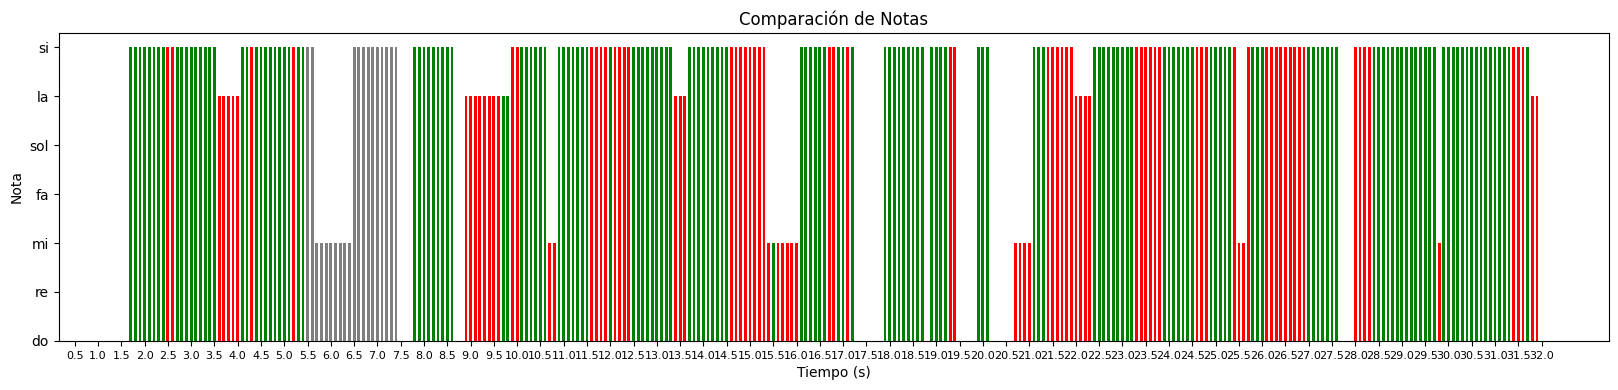

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from google.colab import files

# ------------------ Subir archivo ------------------
def subir_archivo(prompt):
    print(prompt)
    uploaded = files.upload()
    return list(uploaded.keys())[0]

# ------------------ FFT manual ------------------
def fft_manual(x):
    N = len(x)
    N2 = 1 << (N-1).bit_length()  # siguiente potencia de 2
    if N != N2: x = np.pad(x, (0, N2-N), 'constant'); N=N2
    if N <= 1: return x.astype(complex)
    even = fft_manual(x[0::2])
    odd  = fft_manual(x[1::2])
    factor = np.exp(-2j*np.pi*np.arange(N)/N)
    c = np.zeros(N, complex)
    c[:N//2] = even + factor[:N//2]*odd
    c[N//2:] = even - factor[:N//2]*odd
    return c

# ------------------ Notas ------------------
NOTAS = {"do":261.63,"re":293.66,"mi":329.63,"fa":349.23,"sol":392.00,"la":440.00,"si":493.88}
def freq_to_note(freq):
    return min(NOTAS, key=lambda n: abs(NOTAS[n]-freq)) if freq>0 else "Silencio"

# ------------------ Extraer notas ------------------
def extract_notes(path, seconds, chunk_ms=100):
    sig, fs = librosa.load(path, sr=8000, mono=True)
    sig = sig[:int(seconds*fs)]; chunk = int(fs*chunk_ms/1000)
    notas=[]
    for i in range(0, len(sig), chunk):
        seg = sig[i:i+chunk]
        if len(seg)<chunk: break
        if np.max(np.abs(seg))<1e-3: notas.append("Silencio"); continue
        fft_vals = np.abs(fft_manual(seg)[:len(seg)//2])
        freqs = np.fft.rfftfreq(len(seg),1/fs)
        notas.append(freq_to_note(freqs[np.argmax(fft_vals)]))
    return notas

# ------------------ Comparar y graficar ------------------
def compare_and_visualize(ref, stu, chunk_ms=100):
    dt = chunk_ms/1000; length = min(len(ref), len(stu))
    notas_lista = list(NOTAS.keys()); correct=0; colors=[]
    times = np.arange(length)*dt

    print("\n=== RESULTADOS ===")
    for i in range(length):
        r,s = ref[i], stu[i]
        if s=="Silencio" or r=="Silencio": colors.append('gray')
        elif s==r: colors.append('green'); correct+=1
        else: colors.append('red')
        print(f"t={i*dt:.2f}s | Estudiante: {s} | Referencia: {r}{' ✔' if s==r else ' ✘' if s!='Silencio' else ''}")

    print(f"\nPorcentaje de acierto: {correct/length*100:.2f}%\n")

    fig, ax = plt.subplots(figsize=(20,4))
    ax.set_title("Comparación de Notas"); ax.set_xlabel("Tiempo (s)"); ax.set_ylabel("Nota")
    ax.set_yticks(range(len(NOTAS))); ax.set_yticklabels(notas_lista)
    ax.set_xticks(np.arange(0, times[-1]+0.5, 0.5)); ax.tick_params(axis='x', labelsize=8)
    ax.bar(times, [notas_lista.index(n) if n in notas_lista else np.nan for n in stu],
           width=dt*0.6, color=colors, align='center')
    plt.show()

# ------------------ Principal ------------------
def main():
    print("=== COMPARADOR DE NOTAS MUSICALES ===")
    ref_path = subir_archivo("Sube la canción de referencia:")
    stu_path = subir_archivo("Sube la canción del estudiante:")

    while True:
        try:
            seconds = float(input("¿Cuántos segundos analizar?: "))
            if seconds > 0: break
            print("Debe ser mayor que 0.")
        except: print("Número inválido.")

    compare_and_visualize(extract_notes(ref_path, seconds), extract_notes(stu_path, seconds))

if __name__=="__main__":
    main()
